# Personal Uber data analysis

## Get data

CONS: Uber redesigned website to React with data obfuscation. This condition makes data parsing super time-consuming task

PROS: Uber gives you ability to get all your data by request and 0-2 days of waiting (I waited for 6 hours)

https://accounts.uber.com/privacy/exploreyourdata/download

## Parse data

1. Excel
1. https://pistats.io/ (not working, not an ad ;) )
1. Pandas


In [1]:
import pandas as pd
import numpy as np

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.wkt import dumps, loads

In [32]:
df = pd.read_csv('./Uber Data/Rider/trips_data.csv')

df.sample(frac=0.1).head()

,City,Product Type,Trip or Order Status,Request Time,Begin Trip Time,Begin Trip Lat,Begin Trip Lng,Begin Trip Address,Dropoff Time,Dropoff Lat,Dropoff Lng,Dropoff Address,Distance (miles),Fare Amount,Fare Currency
817,Zaporizhia,uberX,COMPLETED,2018-01-15 08:58:32 +0000 UTC,2018-01-15 09:05:24 +0000 UTC,47.836742,35.106979,"Nyzhn'odniprovs'ka St, 4, Zaporizhzhia, Zapori...",2018-01-15 09:18:29 +0000 UTC,47.841414,35.140080,"Sobornyi Ave, 166, Zaporizhzhia, Zaporiz'ka ob...",2.23,43.11,UAH
317,Zaporizhia,UberX,COMPLETED,2018-08-14 15:14:48 +0000 UTC,2018-08-14 15:25:35 +0000 UTC,47.840466,35.140088,"Sobornyi Ave, 166, Zaporizhzhia, Zaporiz'ka ob...",2018-08-14 15:39:39 +0000 UTC,47.839391,35.219030,"Charivna St, 131, Zaporizhzhia, Zaporiz'ka obl...",4.62,67.39,UAH
209,Zaporizhia,UberX,COMPLETED,2018-10-10 17:48:19 +0000 UTC,2018-10-10 17:51:45 +0000 UTC,47.831621,35.163402,"Hoholya St, 171, Zaporizhzhia, Zaporiz'ka obla...",2018-10-10 17:58:36 +0000 UTC,47.839335,35.219039,"Charivna St, 131, Zaporizhzhia, Zaporiz'ka obl...",3.19,54.24,UAH
1067,Zaporizhia,uberX,CANCELED,2017-09-08 15:21:10 +0000 UTC,1970-01-01 00:00:00 +0000 UTC,47.817175,35.176443,NaN,1970-01-01 00:00:00 +0000 UTC,47.817145,35.176497,"Nyzhn'odniprovs'ka St, 4, Zaporizhzhia, Zapori...",0.00,0.00,UAH
683,Zaporizhia,uberX,COMPLETED,2018-03-15 17:37:33 +0000 UTC,2018-03-15 17:45:41 +0000 UTC,47.830521,35.160297,"Sobornyi Ave, 152В, Zaporizhzhia, Zaporiz'ka o...",2018-03-15 18:05:10 +0000 UTC,47.836581,35.107116,"Nyzhn'odniprovs'ka St, 4, Zaporizhzhia, Zapori...",4.02,64.45,UAH


## Know how much you've spent

In [59]:
df['Fare EUR'] = df['Fare Amount'] / df['Fare Currency'].map(lambda c: 27 if c == 'UAH' else 1)
df[['Fare Amount', 'Fare Currency','Fare EUR']] 

,Fare Amount,Fare Currency,Fare EUR
0,94.05,UAH,3.483333
1,104.02,UAH,3.852593
2,65.95,UAH,2.442593
3,60.57,UAH,2.243333
4,0.00,UAH,0.000000
...,...,...,...
1174,0.00,UAH,0.000000
1175,64.45,UAH,2.387037
1176,31.94,UAH,1.182963
1177,0.00,UAH,0.000000


In [61]:
#df['Fare EUR'].sum()
df['Fare EUR'].describe()

count    1179.000000
mean        1.777784
std         2.433122
min         0.000000
25%         0.000000
50%         1.666667
75%         2.548148
max        43.640000
Name: Fare EUR, dtype: float64

In [68]:
df.groupby(['City'])['Fare EUR'].describe()

,count,mean,std,min,25%,50%,75%,max
City,,,,,,,,
Kyiv,69.0,3.313924,2.909695,0.0,2.297037,2.858148,3.695556,18.968889
Paris,8.0,19.595000,15.367146,0.0,11.122500,15.035000,28.480000,43.640000
Stockholm,1.0,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000
Tallinn,7.0,4.430000,2.155984,0.0,4.280000,4.840000,5.585000,6.440000
Zaporizhia,1094.0,1.535262,1.317772,0.0,0.000000,1.631296,2.499074,6.807407


## Know where you took the rides (super demo version, use JS for visualization)

In [3]:
# FIX FOR FRANCE'S LAND IN AMERICA
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
france = world[world.name == 'France']
france['geometry']= [loads('MULTIPOLYGON (((6.186320428094177 49.46380280211451, 6.658229607783568 49.20195831969157, 8.099278598674744 49.01778351500333, 7.593676385131062 48.33301911070372, 7.466759067422231 47.62058197691181, 7.192202182655507 47.44976552997102, 6.736571079138059 47.54180125588285, 6.768713820023606 47.2877082383037, 6.037388950229001 46.72577871356187, 6.022609490593538 46.27298981382047, 6.500099724970426 46.42967275652944, 6.843592970414505 45.99114655210061, 6.802355177445605 45.70857982032864, 7.096652459347837 45.33309886329589, 6.749955275101655 45.02851797136758, 7.007562290076635 44.25476675066136, 7.549596388386107 44.12790110938481, 7.435184767291872 43.69384491634922, 6.52924523278304 43.12889232031831, 4.556962517931424 43.3996509873116, 3.100410597352663 43.07520050716705, 2.985998976258458 42.47301504166986, 1.826793247087153 42.34338471126569, 0.7015906103638941 42.79573436133261, 0.3380469091905809 42.57954600683955, -1.502770961910528 43.03401439063043, -1.901351284177764 43.42280202897834, -1.384225226232985 44.02261037859012, -1.193797573237418 46.01491771095486, -2.225724249673846 47.06436269793822, -2.963276129559603 47.57032664650795, -4.491554938159481 47.95495433205637, -4.592349819344776 48.68416046812699, -3.295813971357802 48.90169240985963, -1.616510789384961 48.64442129169454, -1.933494025063311 49.77634186461574, -0.98946895995536 49.34737580016091, 1.338761020522696 50.12717316344526, 1.6390010921385 50.9466063502975, 2.513573032246143 51.14850617126183, 2.658422071960274 50.79684804951575, 3.123251580425688 50.78036326761455, 3.588184441755658 50.37899241800356, 4.286022983425084 49.90749664977255, 4.799221632515724 49.98537303323637, 5.674051954784829 49.5294835475575, 5.897759230176348 49.44266714130711, 6.186320428094177 49.46380280211451)), ((8.746009148807559 42.62812185319392, 9.390000848028876 43.00998484961471, 9.560016310269134 42.15249197037952, 9.229752231491773 41.38000682226446, 8.775723097375362 41.58361196549443, 8.544212680707773 42.25651662858306, 8.746009148807559 42.62812185319392)))')]
world[world.name == 'France'] = france
print("fixed france for europe")

fixed france for europe


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:557: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


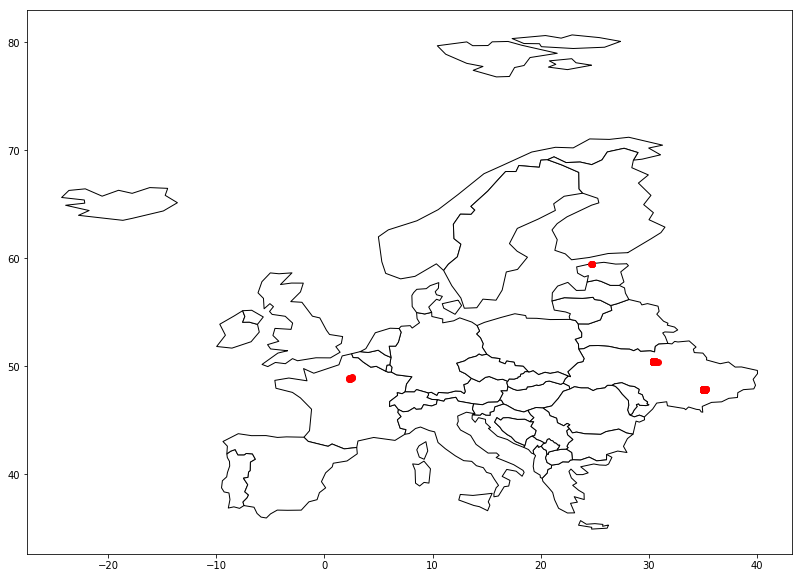

In [6]:
geometry = [Point(xy) for xy in zip(df['Begin Trip Lng'], df['Begin Trip Lat'])]
gdf = GeoDataFrame(df, geometry=geometry)
# gpd.choropleth(world, hue=world['gdp_md_est'] / world['pop_est'],
#     cmap='Greens', figsize=(8, 4)
# )
ax = world[world.continent == 'Europe'][world.name != 'Russia'][world.name != 'Russia'].plot(
    color='white', edgecolor='black', figsize=(20,10))
gdf.plot(ax=ax, color='red')

/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:557: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


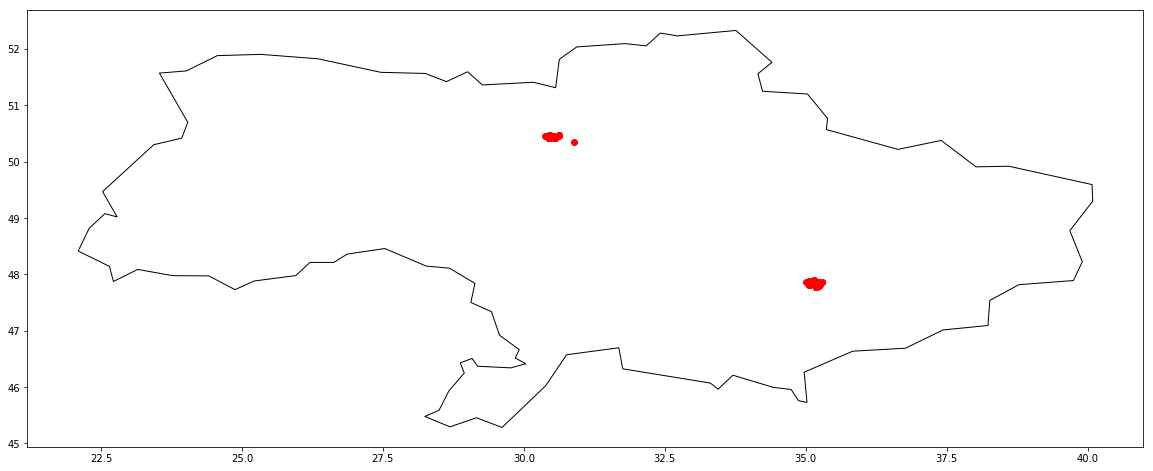

In [8]:
ua_df = df[df['Fare Currency']=='UAH']
geometry = [Point(xy) for xy in zip(ua_df['Begin Trip Lng'], ua_df['Begin Trip Lat'])]
gdf = GeoDataFrame(ua_df, geometry=geometry)
# gpd.choropleth(world, hue=world['gdp_md_est'] / world['pop_est'],
#     cmap='Greens', figsize=(8, 4)
# )
ax = world[world.name == 'Ukraine'].plot(
    color='white', edgecolor='black', figsize=(20,10))
gdf.plot(ax=ax, color='red')

## Basic ML with your data

* We can use scikit-learn to briefly estimate future rides
* Model will predict future ride price based on past data
* Features can be lenght of ride, starting latitude and longitude(in buckets), ride's request time
* Labels will be ride price
* To be more creative and correct, take past weather data and use it as features(can be in buckets also)

### My first AI project. You can put two points on map and get price of taxi ride
![](./first_ai_project.png)


## Super small machine learning model example

* Features: distance of ride, request time
* Label: ride price


In [15]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import datetime

### Distance will be intact, Request time will be converted into integers and scaled

In [12]:
uber_X = pd.DataFrame(df[['Distance (miles)', 'Request Time']])
def time_to_sec(dt):
    t = dt.time()
    return int(datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds())

uber_X['Request Time'] = pd.to_datetime(uber_X['Request Time'].apply(lambda x: x[:len('2017-09-05 15:20:53')])).apply(time_to_sec)

* 00:00:00 = 0
* 00:00:01 = 1
* 00:01:00 = 60
* 15:00:00 = 54000

In [80]:
uber_X

,Distance (miles),Request Time
0,8.23,22465
1,8.47,18426
2,4.29,54522
3,3.54,52868
4,0.00,46422
...,...,...
1174,0.00,17964
1175,7.53,61470
1176,2.48,56852
1177,0.00,56772


In [69]:
uber_Y = pd.DataFrame(df[['Fare EUR']])
uber_Y

,Fare EUR
0,3.483333
1,3.852593
2,2.442593
3,2.243333
4,0.000000
...,...
1174,0.000000
1175,2.387037
1176,1.182963
1177,0.000000


### Let's train model

In [70]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(uber_X, uber_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### We want to take 8 mi ride at 15:00

In [87]:
# 54000 == 15:00 or 3 PM
regr.predict([[2, 54000]])[0][0]

1.2415598008247335